In [207]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import lightgbm
from datetime import datetime

In [208]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [209]:
train_df_final.head()

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,day_frac,dew_point_avg,humidity_avg,...,dew_dep_max,dew_dep_range,pressure_tendency,slp_avg,hum_dep_inter,press_dep_inter,moisture_press_ratio,dp_swing_press,frontal_strength,cc_exp_dp
0,0,-2.707143,-3.992857,115.62,0.017213,0.999852,9.426812,0.392784,-16.808333,46.875000,...,17.2,9.4,-1.9,1034.412500,526.171875,-21.327500,-0.761679,-0.918333,1496.992187,0.308330
1,1,-3.646429,-1.653571,115.62,0.034422,0.999407,9.437325,0.393222,-17.466667,45.500000,...,22.3,15.8,1.1,1035.141667,532.539583,12.874583,-0.767753,0.476667,-874.206667,0.294444
2,2,-2.694643,-0.005357,115.62,0.051620,0.998667,9.448699,0.393696,-17.645833,43.583333,...,22.8,17.0,0.4,1036.045833,537.164583,4.930000,-0.742307,1.146667,-307.625694,0.290774
3,3,-2.501786,-0.898214,115.62,0.068802,0.997630,9.460926,0.394205,-11.966667,53.166667,...,17.8,17.5,-8.7,1031.783333,427.770139,-69.998750,-0.616629,-79.170000,5535.181667,0.432719
4,4,-2.625000,-1.775000,115.62,0.085965,0.996298,9.473997,0.394750,-15.729167,40.583333,...,27.5,28.3,1.6,1027.925000,500.696875,19.740000,-0.621001,8.853333,-1021.347222,0.332525


In [210]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [211]:
lgbm = lightgbm.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lightgbm.log_evaluation(period=0),
               lightgbm.early_stopping(stopping_rounds=100, verbose=False)]
)

y_pred = lgbm.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ LightGBM R²: {r2:.4f} | RMSE: {rmse:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9678
[LightGBM] [Info] Number of data points in the train set: 10505, number of used features: 39
[LightGBM] [Info] Start training from score 0.247066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/opt/miniconda3/envs/ml-arm/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


doy_sin                        1315
slp_avg                        1215
climatology_temp                899
pressure_tendency               842
doy_cos                         841
surface_temp_anomaly            839
humidity_avg                    750
temp_evening_avg                741
press_dep_inter                 700
dp_swing_press                  687
dp_evening_avg                  651
dew_depression_evening          648
temp_night_avg                  640
hum_dep_inter                   616
frontal_strength                609
dew_depression_morning          578
day_length                      545
dew_depression_night            541
temp_dp_interaction_evening     528
dew_dep_min                     520
dtype: int32


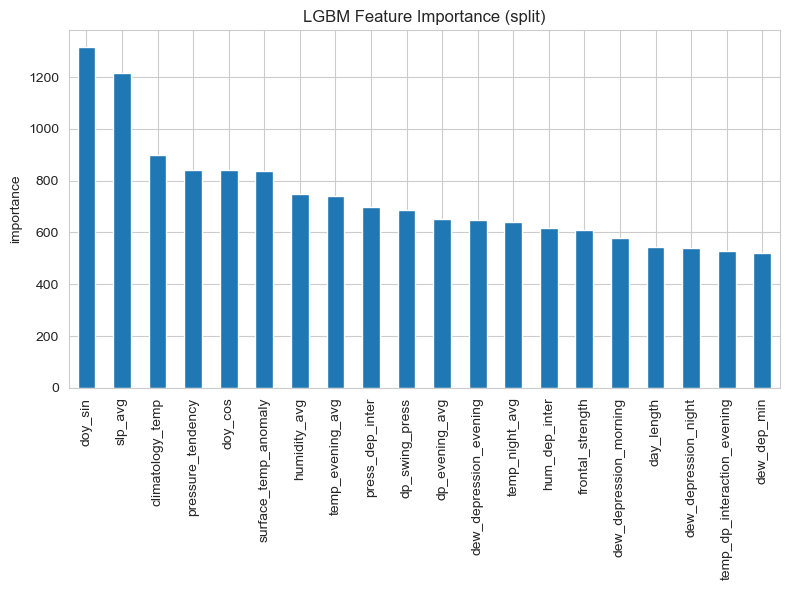

In [212]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get importances (default is by “split” count, you can also use “gain”)
imp_vals = lgbm.feature_importances_            # or lgbm.booster_.feature_importance(importance_type='gain')
imp_type = 'split'                              # or 'gain'
# if you want gain:
# imp_vals = lgbm.booster_.feature_importance(importance_type='gain')
# imp_type  = 'gain'

# 2. Build a Series, sort descending
feat_imp = pd.Series(imp_vals, index=features)
feat_imp = feat_imp.sort_values(ascending=False)

# 3. View top 20
print(feat_imp.head(20))

# 4. Plot
plt.figure(figsize=(8, 6))
feat_imp.head(20).plot(kind='bar')
plt.title(f'LGBM Feature Importance ({imp_type})')
plt.ylabel('importance')
plt.tight_layout()
plt.show()

# Predict with Test Dataset

In [213]:
y_test_pred = lgbm.predict(X_test_scaled)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_{now}.csv', index=False)

/opt/miniconda3/envs/ml-arm/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
